## First use of ReservoirPy
### Example 1

TL;DR : Read only the **bold** text.

The code of this example is also available as an usual python script.

#### Introduction

The goal of this first notebook is to beign the discovery of the features of the _ReservoirPy_ package. **This librairy enables an easy manipulation of Echo States Networks (ESNs).**

They are a class of Recurrent Neural Networks implemented according to Reservoir Computing (RC) paradigm. Below, the figure shows an illustration of ESNs architecture. It is composed by input connexions that lead to a recurrent layer called _the reservoir_. Next comes an output layer called _readout_. The reservoir is randomly initialized and left untrained, while, the readout weights are trained through offline learning or online learning. We can also add feeback connexions to get a richer architecture but for the sake of simplicity we will not consider them in this first example.

![reservoir_illustration.png](https://github.com/neuronalX/reservoirpy/blob/master/examples/reservoir_illustration.png)

(For more information on ESNs, you can check [this paper](https://pdfs.semanticscholar.org/8430/c0b9afa478ae660398704b11dca1221ccf22.pdf), [this one](https://pubmed.ncbi.nlm.nih.gov/17517495/) or to begin, the scholarpedia page [here](http://www.scholarpedia.org/article/Echo_state_network))

#### Goal of the example

This architecture is really efficient to learn sequencial data. Here we will demonstrate its ability by prediciting the chaotic behaviour of the MackeyGlass serie: **the task here will be, given a sequence of steps of the Mackey Glass serie, predict the one that will follow.**
This serie is a solution to a non linerar differential equation and is often used as a benchmark for chaotic time series prediction. (For more detail see [here](http://www.scholarpedia.org/article/Mackey-Glass_equation)). 
10 000 time steps of this sequence are stored in the file `MackeyGlass_t17.txt`. They will be our data to learn from. So first **let's import the data** along with useful packages and **see what the serie looks like.**


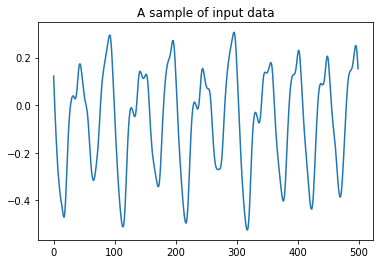

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from reservoirpy import ESN, mat_gen

data = np.loadtxt('MackeyGlass_t17.txt')

# plot some of it to see what it looks like
plt.figure(0).clear()
plt.plot(data[0:500])
plt.title('A sample of input data')
plt.show()

#### Now let's create the ESN ! 

But before that, **we need to initalize the reservoir and the input weight.** They are randomly generated and **they will never change during learning**: as mention in introduction, **only the outpout weights are learned.**
However, even if they are randomly initialized, they are generated with some constraining parameters: **we can specify their sparsity, the spectral radius of the reservoir and obiously the number of neurons in the reservoir.**

For more information on the role of each parameters, see the papers shared in introduction.
For now we'll just choose reasonable values. But in the following examples we'll see how to optimize these hyperparameters with `hyperopt`.


In [3]:
N = 100 #the number of neurons in the reservoir
sr = 1.25 #the spectral radius
sparsity = 0.2 #the sparisity of the reservoir (the number of non zero weights in the link matrix)
nb_features = 1 # We only have one number in input : the previous term of the sequence
regularization_coef =  1e-8 # a regularization coefficient
input_scale_factor = 1.0 # the scaling of the input values : here no rescaling of the input
leak_rate = 0.3

W = mat_gen.fast_spectra_initialization(N, spectral_radius=sr, proba = sparsity) #the weights of the reservoir

Win = mat_gen.generate_input_weights(nbr_neuron=N, dim_input=nb_features, #the input weights
                                    input_bias=True, input_scaling=input_scale_factor)


reservoir = ESN(lr=leak_rate, W=W, Win=Win, input_bias=True, ridge=regularization_coef)

print("the ESN is created !")

#### Data preparation

We divide the sequence in the **training data** and **the test data.** 
**The `wash_initLen` correspond to number of time steps during which internal activations are washed-out during training.** It enables the reservoir not to be determined by a random initial state but by the values of the sequence.
After this warm-up, the output weights are tweaked on every values seen to be better at predicting the next time step. For this, **the ESN created here use an offline learning algorithm** (see the other examples for online learning examples).

In [4]:
wash_initLen = 100 # number of time steps during which internal activations are washed-out during training
# we consider trainLen including the warming-up period (i.e. internal activations that are washed-out when training)
trainLen = wash_initLen + 1900 # number of time steps during which we train the network
testLen = 2000 # number of time steps during which we test the network

train_in = data[None,0:trainLen] # the train sequence at time t
train_out = data[None,0+1:trainLen+1] # the train sequence at time t+1 to be predicted : the teacher

test_in = data[None,trainLen:trainLen+testLen] # the test sequence at time t
test_out = data[None,trainLen+1:trainLen+testLen+1] # the test sequence at time t+1 to be predicted

# We reshape them to be compatible with the shape expected for the ESN
train_in, train_out = train_in.T, train_out.T
test_in, test_out = test_in.T, test_out.T

print( "train_in, train_out dimensions", train_in.shape, train_out.shape)
print( "test_in, test_out dimensions", test_in.shape, test_out.shape)

#### Now train the ESN !

**It's a single line** : we just need to precise the data that it needs to learn from.

In [5]:

internal_states_train = reservoir.train(inputs=[train_in,], teachers=[train_out,], wash_nr_time_step=wash_initLen, verbose=False)

print("the ESN is trained !")


#### Let's test it

When we run the reservoir, we have, as a return value, the output prediction on the `test_in` data but also the sequence of internal states the reservoir had gone through during the execution. 

In [7]:
#We keep the last state of the reservoir because the test sequence follow the train sequence.
# You can use the `init_state` option to `run` to specify another initial state 

output_pred, internal_states_sequence = reservoir.run(inputs=[test_in,])

print("The test is done")

We can **compute the error** on the test data and **plot the prediction.** We can also plot the evolution of some of the internal states of the reservoir.

Mean Squared error :  8.642800018410241e-07
Root Mean Squared error :  0.0009296666078982423


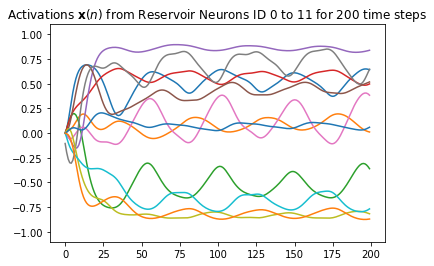

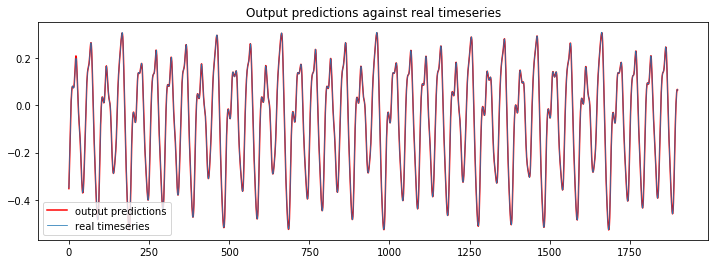

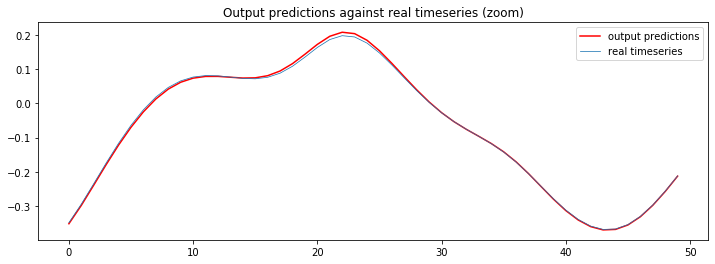

In [8]:

#we only take into account the results after the `wash_initLen` first steps

mse = np.mean((test_out[wash_initLen:] - output_pred[0][wash_initLen:])**2) # Mean Squared Error: see https://en.wikipedia.org/wiki/Mean_squared_error for more details
rmse = np.sqrt(mse) # Root Mean Squared Error

print("Mean Squared error : ", mse)
print("Root Mean Squared error : ", rmse)


plt.figure()
plt.plot( internal_states_sequence[0][:200,:12])
plt.ylim([-1.1,1.1])
plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neurons ID 0 to 11 for 200 time steps')


plt.figure(figsize=(12,4))
plt.plot(output_pred[0][wash_initLen:], color='red', lw=1.5, label="output predictions")
plt.plot(test_out[wash_initLen:], lw=0.75, label="real timeseries")
plt.title("Output predictions against real timeseries")
plt.legend()

plt.figure(figsize=(12,4))
plt.plot(output_pred[0][wash_initLen:wash_initLen + 50], color='red', lw=1.5, label="output predictions")
plt.plot(test_out[wash_initLen:wash_initLen + 50], lw=0.75, label="real timeseries")
plt.title("Output predictions against real timeseries (zoom)")
plt.legend()

plt.show()

It (hopefully) learned pretty well the sequence !

This was a pretty basic example of ESN with offline learning, you can see the other examples to delve in a more detailed approach to ESNs !